# Scalable K-Means++

STA - 663 - Final Project 

Yunlu Hao & Lianghui Li

https://github.com/yumegaaru/Scalable_Kmeans

# Abstract  

K-means is one of the most common data processing algorithms. The algorithms obtain an excellent final solution by employing proper initialization. However, from a theoretical perspective concerning quality and efficiency, k-means is not a suitable clustering algorithm. This is because in the worst case it produces a final solution which is locally optimal, although it doesn't meet the typical global optimum. Besides, this paper will discuss the keys that were applied in the process improving k-means from traditional to the current modern algorithm. The big step taken was to develop the initialization procedure of traditional k-means which changed the performance of Lloyd's iteration. The improvement resulted in k-means++ algorithm which improves upon the running time of iteration. The algorithm picks only the first cluster center consistently at random from the data and probability is used in selecting the subsequent cluster center. Initialization of k-means++ leads to an O(log K) which is an approximation of the solution optimum. However, K-means++ algorithm has its downside which is being intrinsically sequential. Although it has a total running of 0(nkd), its k-clustering is similar to that of a single Lloyd's iteration. The downside led to obtainment a parallel version of k-means++ known as k-means||. The k-means|| algorithm uses the idea of sampling O(k) points per round, and the process is repeated to O(log n) rounds. Moreover, at the end the algorithm only O(k log n) points are left, which form a solution in a constant factor.

Key words: kmeans, kmeans++, kmeansII, jit, cython, multi-core parallel

# Table of Contents

### 1. Backgound

### 2. Application of Algorithm

### 3. Algorithm Implementation
> 3.1 Kmeans <br>
> 3.2 Kmeans++ <br>
> 3.3 KmeansII <br>


### 4. Optimization
> 4.1 JIT <br>
> 4.2 Cdist <br>
> 4.3 Cython <br>
> 4.4 Multi-core parallel <br>

### 5. Applications
(Including test plot, time efficiency, cost)
> 5.1 Simulated Data <br>
> 5.2 Real World Data - Housing Data<br>
> 5.3 Real World Data - Spambase<br>

### 6. Comparative Analysis
> 6.1 Kmeans <br>
> 6.2 Hierarchical K-Means<br>

### 7 Discussion

### 8 Reference

<br>

<br>

# 1. Background

In data mining and processing, some specifics algorithms are applied to cluster or group the data to meaningful information. Those algorithms are referred as clustering algorithms. In this case, scalable k-means paper is used in the research about of k-means algorithms, their efficiency in operation and the solution they offer in data mining processes. K-means clustering algorithms are used when data is unbalanced that is data without defined groups or categories (Bahmani, Moseley, Vattani, Kumar & Vassilvitskii, 2012). These algorithms aim to group data into clusters whereby variable k represents the number of groups or cluster. Besides, the algorithm works iteratively to allocate every data point to a single k group by use of provided attributes. It should be noted that data points are clustered on the ground of feature similarity. K-means results in centroids of the k clusters that are used in new data labeling and markers for the training data.

# 2. Application of the Algorithm

The k-means algorithm can be useful in almost all the fields. The algorithm is used in data clustering applications in different areas (Bahmani, Moseley, Vattani, Kumar & Vassilvitskii, 2012). For instance, clustering helps marketers advance their customers base as well as work on the goal areas. The k-means help group people using different criteria including purchasing power and willingness. The grouping is on the basis of their similarity in several ways which are related to the product under deliberation. In addition, clustering can be used to study earthquake. K-means analyses shows the next likely location where an earthquake can transpire by use of available data on the areas hit by the quake in a region. Moreover, k-means algorithm is mostly applied in large database management systems whereby data is mined, cleaned and analyzed for useful information. The advantage of k-means is that it is computationally faster than other clustering algorithms such as hierarchical clustering algorithm. The main disadvantage is that k-means cannot grip non-globular data of diverse sizes and densities.

# 3. Implementation 

Loading libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.spatial.distance as dist
import collections 
import time
import warnings
warnings.filterwarnings('ignore')

from sklearn.cluster import KMeans


In [2]:
#Function to determine the running time of a function
def timer(f, *args, **kwargs):
    ''' 
        Function to return efficiency(in terms of time) of running function f
        Input: f, function. *args, argument that need when running f
        Output: time elapsed on creating output from f 
    '''
    start = time.clock()
    ans = f(*args, **kwargs)
    return time.clock() - start

## 3.1 Kmeans

K-means clustering is a type of unsupervised learning, which is used when you have unlabeled data. The goal of this algorithm is to find groups in the data, with the number of groups represented by the variable K. The algorithm works iteratively to assign each data point to one of K groups based on the features that are provided. Data points are clustered based on feature similarity. 

### 3.1.1 Algorithm

**Initialize cluster centroids $\mu_1, \mu_2....\mu_k \in \mathbb{R}^n$ randomly** <br>
Repeat until convergence:{<br> 
+ For every i, set <br>
> $c^{(i)}:= argmin||x^{(i)} - u_j||^2$  <br>
+ For every j, set<br>
> $\mu_j := \frac{\sum_{i=1}^{m} 1 \{c^{(i) = j}\}x^{(i)}}{\sum_{i=1}^{m} 1\{c^{(i) = j}\}}$<br>

}

### 3.1.2 Code

In [3]:
def distance(X, Y):
    ''' 
        Function to return distance matrix between every observation to each centroids   
        Input: X, observations of data. Y, centriod from clustering
        Output: dist, distance matrix. 
    '''
    dist = np.empty((X.shape[0], Y.shape[0]), dtype=np.float)
    for k in range(X.shape[0]):
        for i in range(Y.shape[0]):
            temp = 0
            for j in range(X.shape[1]):
                temp = temp +(X[k,j] - Y[i,j])**2
            dist[k, i]= temp**0.5
    return dist

In [4]:
def kmeans(data, k, centroids, max_iter=10000):
    ''' 
        Function to return final centers for the using k-means clustering algorithm and 
        jit_distance function to calculate distance matrix
        
        Input: data, an array of data. k, the number of clusters. centroids, initial centroids
        Output: C, an array with length k of initial cluster centers. 
    '''
    for i in range(max_iter):
        cdist = (distance(data, centroids))**2
        labels = np.argmin(cdist, axis=1)
        update_centroids = np.zeros(centroids.shape)
        for j in range(k):
            # check if the centroid is the closest to some data point
            if sum(labels == j) != 0:
                update_centroids[j] = np.mean(data[labels ==j], axis=0)
            else:
                # if not, leave the lone centroid unmoved
                update_centroids[j] = centroids[j]
                
        if np.allclose(update_centroids, centroids):
            print("Algorithm converged after", i, "iterations.")
            return ({"Centroids": centroids, 
                      "Labels": labels})
        else:
            centroids = update_centroids
        
    print("Warning: maximum number of iterations reached. Failed to converge.")
    return({"Centroids": centroids, 
            "Labels": labels})

#### Random initial centroids

In [5]:
def main():
    k, n, d = 20, 1000, 15
    
    mean, cov = np.zeros(d), np.eye(d)
    data = np.random.multivariate_normal(mean, cov, n)
    #random initial 
    initial_centers = np.random.multivariate_normal(mean, cov, k)
    
    centroids = kmeans(data, k, initial_centers)['Centroids']

if __name__ == '__main__':
    main()


Algorithm converged after 41 iterations.


## 3.2 Kmeans++

Instead of just select the centers randomly, Kmeans++ selects only the first center uniformly at random from the data. Each subsequent center is selected with a probability proportional to its contribution to the overall error given the precious selections. 

### 3.2.1 Algorithm

**Choose the centers one by onte in a controlled fasion, where the current set of chosen centers will stochastically bias the choice of the next center**<br>

First sample a point uniformly at random from X : C<br>
Set how many clusters are needed: k <br>
Distance between points and centers: $d^2(x, C)$<br>
Compute the cost of X: $\phi x(C) = \sum_{x\in X} min_{i=1,..k} ||y - c_i||^2$<br>
While |C| < k do:
+ Sample x $\in$ X with probability $p_x = \frac{d^2(x, C)}{\phi x(C)}$ <br>
+ Stack C with {x}: C = C $\cup$ {x} <br> 

end while

### 3.2.1 Code

In [6]:
def kmeans_pp(data, k, weights):
    ''' 
        Function to return final centers for the using k-means++ clustering algorithm
        Input: data, an array of data. k, the number of clusters. weights, weight for each centroid
        Output: C, an array with length k of initial cluster centers. 
    '''
    np.random.seed(663)
    first_random = np.random.choice(data.shape[0], 1)
    C = data[first_random, :]
    
    for i in range(k-1):
        cdist = (distance(data, C))**2
        cdist_min = np.min(cdist, axis = 1)* weights
        prob = cdist_min/np.sum(cdist_min)
        np.random.seed(663)
        new_center = np.random.choice(data.shape[0],1, p=prob)
        C = np.vstack([C, data[new_center,:]])
        
    return C

#### Equal weights for kmenas++

In [7]:
def main():
    k, n, d = 20, 1000, 15
    
    mean, cov = np.zeros(d), np.eye(d)
    data = np.random.multivariate_normal(mean, cov, n)
    #equal weights for kmenas++
    initial_centers = kmeans_pp(data, 20, 1)
    
    centroids = kmeans(data, k, initial_centers)['Centroids']


if __name__ == '__main__':
    main()

Algorithm converged after 37 iterations.


## 3.3 Kmeans_II

Instead of sampling a single point in each pass of the kmeans++ algorithm, we sample O(k) points in each round and repeat the process for approximately O(logn) rounds. 

### 3.3.1 Algorithm

**Parallel version of Kmeans++**<br>

First set an oversampling factor l = $\Omega(K)$<br>
Sample a point uniformly at random from X : C<br>
Set how many clusters are needed: k <br>
Distance between points and centers: $d^2(x, C)$<br>
Compute the cost of X: $\phi x(C) = \sum_{x\in X} min_{i=1,..k} ||y - c_i||^2$<br>

for O(log($\phi$)) times do:
+ Sample each point x $\in$ X independently with probability $p_x = \frac{l * d^2(x, C)}{\phi x(C)}$ <br>
+ Stack C with {x}: C = C $\cup$ {x} <br> 

end for<br>
For each point x$\in$ C, compute $w_x$ to be the number of points in X closer than other points in C<br>
Recluster the weighted points in C into k clusters. 

### 3.3.2 Code

#### Compute each weight

In [8]:
def get_weight(C, data): 
    ''' 
        Function to return  weight for each centorid
        Input: data, an array of data. centroids, initial centroids
        Output: C, an array with length k of weight for cluster centers. 
    '''
    weights=np.zeros(C.shape[0])
    cdist = (distance(data,C))**2
    min_cdist = np.argmin(cdist, axis = 1)
    count = collections.Counter(min_cdist) 
    weights = list(collections.OrderedDict(sorted(count.items(), key=lambda x: x[0])).values())
    weights=np.array(weights)/sum(weights)
    return weights

In [9]:
def kmeans_II(data, k, l, max_iter=10000):
    ''' 
        Function to return final centers for the using k-means|| clustering algorithm
        Input: data, an array of data. k, the number of clusters. l, oversampling factor
        Output: C, an array with length k of initial cluster centers. 
    '''
    first_random = np.random.choice(data.shape[0], 1)
    C = data[first_random, :]
    
    cdist = (distance(data, C))**2
    cdist_min = np.min(cdist, axis = 1)
    cost_phi = np.sum(cdist_min)
    
    for i in range(int(round(np.log(cost_phi)))):
        cdist = (distance(data, C))**2
        cdist_min = np.min(cdist, axis = 1)
        prob = cdist_min * l/np.sum(cdist_min)
        for j in range(data.shape[0]):
            if np.random.uniform() <= prob[j] and data[j,:] not in C:
                C = np.vstack([C, data[j,:]])
   
    weights= get_weight(C, data)

    return kmeans_pp(C, k, weights)
    

#### Initial centroids with weights

In [10]:
def main():
    k, n, d = 20, 1000, 15
    
    mean, cov = np.zeros(d), np.eye(d)
    data = np.random.multivariate_normal(mean, cov, n)
    #initial with weight 
    initial_centers = kmeans_II(data, 20, 10)
    
    centroids = kmeans(data, k, initial_centers)['Centroids']

if __name__ == '__main__':
    main()

Algorithm converged after 17 iterations.


# 4. Optimization

## 4.1 JIT Implementation

In [11]:
import numba
from numba import jit

Since in the normal version, I use the distance function from python. In order to use jit, I need to rewrite the distance function.

In [12]:
@jit 
def jit_distance(X, Y):
    ''' 
        Function to return distance matrix between every observation to each centroids   
        Input: X, observations of data. Y, centriod from clustering
        Output: dist, distance matrix. 
    '''
    dist = np.empty((X.shape[0], Y.shape[0]), dtype=np.float)
    for k in range(X.shape[0]):
        for i in range(Y.shape[0]):
            temp = 0
            for j in range(X.shape[1]):
                temp = temp +(X[k,j] - Y[i,j])**2
            dist[k, i]= temp**0.5
    return dist

### 4.1.1 Kmeans

In [13]:
@jit 
def jit_kmeans(data, k, centroids, max_iter=10000):
    ''' 
        Function to return final centers for the using k-means clustering algorithm and 
        jit_distance function to calculate distance matrix
        
        Input: data, an array of data. k, the number of clusters. centroids, initial centroids
        Output: C, an array with length k of initial cluster centers. 
    '''
    for i in range(max_iter):
        cdist = (jit_distance(data, centroids))**2
        labels = np.argmin(cdist, axis=1)
        update_centroids = np.zeros(centroids.shape)
        for j in range(k):
            # check if the centroid is the closest to some data point
            if sum(labels == j) != 0:
                update_centroids[j] = np.mean(data[labels ==j], axis=0)
            else:
                # if not, leave the lone centroid unmoved
                update_centroids[j] = centroids[j]
                
        if np.allclose(update_centroids, centroids):
            print("Algorithm converged after", i, "iterations.")
            return ({"Centroids": centroids, 
                      "Labels": labels})
        else:
            centroids = update_centroids
        
    print("Warning: maximum number of iterations reached. Failed to converge.")
    return ({"Centroids": centroids, 
                      "Labels": labels})

### 4.1.2 Kmeans++

In [14]:
@jit 
def jit_kmeans_pp(data, k, weights):
    ''' 
        Function to return final centers for the using k-means++ clustering algorithm
        Input: data, an array of data. k, the number of clusters. weights, weight for each centroid
        Output: C, an array with length k of initial cluster centers. 
    '''
    first_random = np.random.choice(data.shape[0], 1)
    C = data[first_random, :]
    
    for i in range(k-1):
        cdist = (jit_distance(data, C))**2
        cdist_min = np.min(cdist, axis = 1)* weights
        prob = cdist_min/np.sum(cdist_min)
        new_center = np.random.choice(data.shape[0],1, p=prob)
        C = np.vstack([C, data[new_center,:]])
        
    return C


### 4.1.3 Kmeans_II

In [15]:
@jit
def jit_kmeans_II(data, k, l, max_iter=10000):
    ''' 
        Function to return final centers for the using k-means|| clustering algorithm
        Input: data, an array of data. k, the number of clusters. l, oversampling factor
        Output: C, an array with length k of initial cluster centers. 
    '''
    first_random = np.random.choice(data.shape[0], 1)
    C = data[first_random, :]
    
    cdist = (jit_distance(data, C))**2
    cdist_min = np.min(cdist, axis = 1)
    cost_phi = np.sum(cdist_min)
    
    for i in range(int(round(np.log(cost_phi)))):
        cdist = (jit_distance(data, C))**2
        cdist_min = np.min(cdist, axis = 1)
        prob = cdist_min * l/np.sum(cdist_min)
        for j in range(data.shape[0]):
            if np.random.uniform() <= prob[j] and data[j,:] not in C:
                C = np.vstack([C, data[j,:]])
   
    weights= get_weight(C, data)

    return jit_kmeans_pp(C, k, weights)


## 4.2 cdist Implementation

Based on our time testing, we found out that the most time consuming function is distance function. Thus instead of using normal distance or jit distance, here we use cdist in scipy package

### 4.2.1 Kmeans

In [16]:
def cdist_kmeans(data, k, centroids, max_iter=10000):
    ''' 
        Function to return final centers for the using k-means clustering algorithm and 
        cdist function to calculate distance matrix
        
        Input: data, an array of data. k, the number of clusters. centroids, initial centroids
        Output: C, an array with length k of initial cluster centers. 
    '''
    
    for i in range(max_iter):
        cdist = (dist.cdist(data, centroids))**2
        labels = np.argmin(cdist, axis=1)
        update_centroids = np.zeros(centroids.shape)
        for j in range(k):
            # check if the centroid is the closest to some data point
            if sum(labels == j) != 0:
                update_centroids[j] = np.mean(data[labels ==j], axis=0)
            else:
                # if not, leave the lone centroid unmoved
                update_centroids[j] = centroids[j]
                
        if np.allclose(update_centroids, centroids):
            print("Algorithm converged after", i, "iterations.")
            return ({"Centroids": centroids, 
                      "Labels": labels})
        else:
            centroids = update_centroids
        
    print("Warning: maximum number of iterations reached. Failed to converge.")
    return centroids

### 4.2.2 Kmeans++

In [17]:
def cdist_kmeans_pp(data, k, weights):
    ''' 
        Function to return final centers for the using k-means++ clustering algorithm
        Input: data, an array of data. k, the number of clusters. weights, weight for each initial centroids
        Output: C, an array with length k of initial cluster centers. 
    '''
    first_random = np.random.choice(data.shape[0], 1)
    C = data[first_random, :]
    
    for i in range(k-1):
        cdist = (dist.cdist(data, C))**2
        cdist_min = np.min(cdist, axis = 1)* weights
        prob = cdist_min/np.sum(cdist_min)
        new_center = np.random.choice(data.shape[0],1, p=prob)
        C = np.vstack([C, data[new_center,:]])
        
    return C

### 4.2.3 Kmeans_II

In [18]:
def cdist_get_weight(C, data):
    ''' 
        Function to return  weight for each centorid
        Input: data, an array of data. centroids, initial centroids
        Output: C, an array with length k of weight for cluster centers. 
    '''
    weights=np.zeros(C.shape[0])
    cdist = (dist.cdist(data,C))**2
    min_cdist = np.argmin(cdist, axis = 1)
    count = collections.Counter(min_cdist) 
    weights = list(collections.OrderedDict(sorted(count.items(), key=lambda x: x[0])).values())
    weights=np.array(weights)/sum(weights)
    return weights

In [19]:
def cdist_kmeans_II(data, k, l, max_iter=10000):
    ''' 
        Function to return final centers for the using k-means|| clustering algorithm
        Input: data, an array of data. k, the number of clusters. l, oversampling factor
        Output: C, an array with length k of initial cluster centers. 
    '''
    first_random = np.random.choice(data.shape[0], 1)
    C = data[first_random, :]
    
    cdist = (dist.cdist(data, C))**2
    cdist_min = np.min(cdist, axis = 1)
    cost_phi = np.sum(cdist_min)
    
    for i in range(int(round(np.log(cost_phi)))):
        cdist = (dist.cdist(data, C))**2
        cdist_min = np.min(cdist, axis = 1)
        prob = cdist_min * l/np.sum(cdist_min)
        for j in range(data.shape[0]):
            if np.random.uniform() <= prob[j] and data[j,:] not in C:
                C = np.vstack([C, data[j,:]])
   
    weights= cdist_get_weight(C, data)

    return cdist_kmeans_pp(C, k, weights)

## 4.3: Cython

In [20]:
%load_ext cython

### 4.3.1: Kmeans

In [21]:
%%cython --annotate

cimport cython
import numpy as np
cimport numpy as np
from libc.math cimport exp
from scipy.spatial import distance as dist
from numpy.math cimport INFINITY

@cython.boundscheck(False)
@cython.wraparound(False)
@cython.cdivision(True)

def kmeans_cython(double[:,:]data, int k, double[:,:] centroids, int max_iter=10000):
    ''' 
        Function to return final centers for the using k-means clustering algorithm
        Input: data, an array of data. k, the number of clusters. centroids, initial centroids
        Output: C, an array with length k of initial cluster centers. 
    '''
    cdef int i,j
    cdef double[:,:] update_centroids
    cdef double[:,:] cdist
    cdef double[:] labels
    cdef double min_dist
    cdef int min_dist_index
    cdef int total_sum 
    cdef double[:] label_sum
    cdef double label_total
    cdef int n  = data.shape[0]
    cdef int p = data.shape[1]
    
    
    for i in range(max_iter):
        cdist = dist.cdist(data, centroids)
        labels = np.zeros(n)
        #finding the label(columns) corresponding to minimum distance for observation z
        for z in range(n):
            min_dist = INFINITY
            for h in range(k):
                if cdist[z,h] < min_dist:
                    min_dist = cdist[z,h]
                    min_dist_index = h
            labels[z] = min_dist_index
        
        update_centroids = np.empty([centroids.shape[0],centroids.shape[1]])
        for j in range(k):
            # check if the centroid is the closest to some data point
            total_sum = 0
            for y in range(n):
                if(labels[y] == j):
                    total_sum +=1
            if total_sum != 0:
                label_sum = np.zeros(p)
                for t in range(n):
                    if labels[t] == j:
                        for b in range(p):
                            label_sum[b] = label_sum[b] + data[t,b]                              
                #calculating the average of the centroid(for each features)
                for a in range(p):
                    update_centroids[j,a] = label_sum[a] / total_sum
            else:
                update_centroids[:,j] = centroids[:,j]
                
        #rounding check if update centroid are the same the one before
        if np.allclose(update_centroids,centroids):
            print("Algorithm converged after", i, "iterations.")
            return [labels,centroids]
        else:
            centroids = update_centroids
        
    print("Warning: maximum number of iterations reached. Failed to converge.")
    
    return centroids


### 4.3.2: Kmeans++

In [22]:
%%cython --annotate

cimport cython
import numpy as np
cimport numpy as np
from libc.math cimport exp
from scipy.spatial import distance as dist
from numpy.math cimport INFINITY


@cython.boundscheck(False)
@cython.wraparound(False)
@cython.cdivision(True)

def kmeans_pp_cython(double[:] weights, data, int k,  int max_iter=10000):
    ''' 
        Function to return final centers for the using k-means++ clustering algorithm
        Input: data, an array of data. k, the number of clusters. weights, weight for each initial centroids
        Output: C, an array with length k of initial cluster centers. 
    '''
    cdef int first_random, new_center
    cdef double[:,:] C
    cdef int i,j,h,l
    cdef double[:,:] cdist
    cdef double min_dist
    cdef double [:] cdist_min
    cdef int n = data.shape[0]
    cdef double [:] cdist_min_weighted
    cdef double [:] cdist_min_weighted_sq
    cdef double [:] prob
    
    np.random.seed(663)
    #initial the first centroid
    first_random = np.random.choice(data.shape[0], 1)
    C = data[first_random, :].reshape(1,-1)
    
    for i in range(k-1):
        #creating distance matrix
        cdist = dist.cdist(data, C)
        cdist_min = np.empty(n)
        
        for j in range(n):
            min_dist = INFINITY
            for l in range(k):
                if cdist[j,l] < min_dist:
                    min_dist = cdist[j,l]
            #finding the minimum distance for each observation
            cdist_min[j] = min_dist
            
        cdist_min_weighted = np.empty(n)
        for h in range(n):
            #update distance with weight
            cdist_min_weighted[h] = cdist_min[h] * weights[h]
        cdist_min_weighted_sq = np.empty(n)
        for l in range (n):
            cdist_min_weighted_sq[l] = pow(cdist_min_weighted[l],2)
            
        prob = np.empty(n)
        
        for g in range(n):
            #calculate the probability for each observation
            prob[g] = cdist_min_weighted_sq[g] / sum(cdist_min_weighted_sq)
        np.random.seed(663)
        new_center = np.random.choice(data.shape[0],1, p=prob)
        C = np.vstack([C, data[new_center,:]])
        
    return C

### 4.3.3: KmeansII

In [23]:
%%cython --annotate

cimport cython
import numpy as np
cimport numpy as np
from libc.math cimport exp
from scipy.spatial import distance as dist
from numpy.math cimport INFINITY
import collections

@cython.boundscheck(False)
@cython.wraparound(False)
@cython.cdivision(True)

def get_weight_cython(double[:,:] C, data):
    ''' 
        Function to return  weight for each centorid
        Input: data, an array of data. centroids, initial centroids
        Output: C, an array with length k of weight for cluster centers. 
    '''
    cdef double[:,:] cdist
    cdef double[:] labels
    cdef k = C.shape[0]
    cdef n = data.shape[0]
    cdef p = data.shape[1]
    cdef double[:] fin_weight
    
    weights=np.empty(k)
    cdist = dist.cdist(data,C)      
    labels = np.empty(n)
        
    for z in range(n):
        min_dist = INFINITY
        for h in range(k):
            if cdist[z,h] < min_dist:
                min_dist = cdist[z,h]
                min_dist_index = h
        labels[z] = min_dist_index
    
    #create dictonary that count numbers of observation that is nearest to that specific centroid
    count = collections.Counter(labels) 
    #sort the dict based on its value
    weights = list(collections.OrderedDict(sorted(count.items(), key=lambda x: x[0])).values())
    
    
    fin_weight = np.empty(k)
    
    for a in range(k):
        fin_weight[a] = weights[a]/sum(weights)
        
    return fin_weight

In [24]:
%%cython --annotate

cimport cython
import numpy as np
cimport numpy as np
from libc.math cimport exp
from scipy.spatial import distance as dist
from numpy.math cimport INFINITY
import collections

@cython.boundscheck(False)
@cython.wraparound(False)
@cython.cdivision(True)

def kmeans_pp_cython(double[:] weights, data, int k,  int max_iter=10000):
    ''' 
        Function to return final centers for the using k-means++ clustering algorithm
        Input: data, an array of data. k, the number of clusters. weights, weight for each initial centroids
        Output: C, an array with length k of initial cluster centers. 
    '''
    cdef int first_random, new_center
    cdef double[:,:] C
    cdef int i,j,h,l
    cdef double[:,:] cdist
    cdef double min_dist
    cdef double [:] cdist_min
    cdef int n = data.shape[0]
    cdef double [:] cdist_min_weighted
    cdef double [:] cdist_min_weighted_sq
    cdef double [:] prob
    
    np.random.seed(663)
    first_random = np.random.choice(data.shape[0], 1)
    C = data[first_random, :].reshape(1,-1)
    
    for i in range(k-1):
        cdist = dist.cdist(data, C)
        cdist_min = np.empty(n)
        
        for j in range(n):
            min_dist = INFINITY
            for l in range(k):
                if cdist[j,l] < min_dist:
                    min_dist = cdist[j,l]
            cdist_min[j] = min_dist
            
        cdist_min_weighted = np.empty(n)
        for h in range(n):
            cdist_min_weighted[h] = cdist_min[h] * weights[h]
        cdist_min_weighted_sq = np.empty(n)
        for l in range (n):
            cdist_min_weighted_sq[l] = pow(cdist_min_weighted[l],2)
            
        prob = np.empty(n)
        
        for g in range(n):
            prob[g] = cdist_min_weighted_sq[g] / sum(cdist_min_weighted_sq)
        np.random.seed(663)
        new_center = np.random.choice(data.shape[0],1, p=prob)
        C = np.vstack([C, data[new_center,:]])
        
    return C

@cython.boundscheck(False)
@cython.wraparound(False)
@cython.cdivision(True)

def get_weight_cython(double[:,:] C, data):
    ''' 
        Function to return  weight for each centorid
        Input: data, an array of data. centroids, initial centroids
        Output: C, an array with length k of weight for cluster centers. 
    '''
    cdef double[:,:] cdist
    cdef double[:] labels
    cdef k = C.shape[0]
    cdef n = data.shape[0]
    cdef p = data.shape[1]
    cdef double[:] fin_weight
    
    weights=np.empty(k)
    cdist = dist.cdist(data,C)
    labels = np.empty(n)
        
    for z in range(n):
        min_dist = INFINITY
        for h in range(k):
            if cdist[z,h] < min_dist:
                min_dist = cdist[z,h]
                min_dist_index = h
        labels[z] = min_dist_index
    
    count = collections.Counter(labels) 
    weights = list(collections.OrderedDict(sorted(count.items(), key=lambda x: x[0])).values())
    
    
    fin_weight = np.empty(k)
    
    for a in range(k):
        fin_weight[a] = weights[a]/sum(weights)
        
    return fin_weight

@cython.boundscheck(False)
@cython.wraparound(False)
@cython.cdivision(True)

def kmeans_II_cython(data, int k, double l):
    ''' 
        Function to return final centers for the using k-meansII clustering algorithm
        Input: data, an array of data. k, the number of clusters. l, oversampling factor
        Output: C, an array with length k of initial cluster centers. 
    '''
    cdef double[:,:] C
    cdef int first_random
    cdef double[:] cdist_min
    cdef double cost_phi
    cdef int n = data.shape[0]
    cdef double[:] prob
    cdef int i,j,h,t,q,s 
    
    first_random = np.random.choice(data.shape[0], 1)
    C = data[first_random, :].reshape(1,-1)  
    cdist = dist.cdist(data, C)
        
        
    cdist_min = np.empty(n)
        
    for j in range(n):
        min_dist = INFINITY
        s = C.shape[0]
        for q in range(s):
             if cdist[j,q] < min_dist:
                min_dist = cdist[j,q]
        cdist_min[j] = min_dist
    cost_phi = sum(cdist_min)
    
    for i in range(int(round(np.log(cost_phi)))):  
        cdist = dist.cdist(data, C)
             
        cdist_min = np.empty(n)
        
        for j in range(n):
            min_dist = INFINITY
            s = C.shape[0]
            for q in range(s):
                if cdist[j,q] < min_dist:
                    min_dist = cdist[j,q]
            cdist_min[j] = min_dist
            
        prob = np.empty(n)
        
        for h in range(n):
            prob[h] = cdist_min[h] * l/sum(cdist_min)
        for t in range(n):
            if np.random.uniform() <= prob[t]:
                #combine each new centroid
                C = np.vstack([C, data[t,:]])

   
    weights= get_weight_cython(C, data)

    C_np = np.asarray(C)
    return kmeans_pp_cython(weights, C_np,k)

## 4.4: Multi-Core Parallelism


In [25]:
import multiprocessing as mp
from functools import partial

In [26]:
def min_distance(d, centroids):
    """
    function return the minimum distance from point d to nearest centroids
    """
    dist = np.min(np.sum((centroids - d)**2, axis=1))
    return dist

def cost_p(data, centroids): 
    """
    function that return the cost(distance) for each observation
    """

    with mp.Pool(processes = mp.cpu_count()) as pool:
        partial_dist = partial(min_distance, centroids = centroids)
        min_dist = pool.map(partial_dist, data)
        p = min_dist/np.sum(min_dist)
    return p


def random_choice(x, a, p):
    """
    helper function like np.random.choice
    but have one less argument and shift order of arguments for future map
    """
    np.random.seed()
    return np.random.choice(a = a, size = x , p =p)


def sample_p(data, distribution, l):
    
    """ 
    Function to sample l number new centers
    """  
    
    with mp.Pool(processes = mp.cpu_count()) as pool:
        partial_rc = partial(random_choice, a = len(distribution), p=distribution)
        #create l number of size one observation
        index = pool.map(partial_rc,np.repeat(1,l))
    return np.squeeze(data[index,:],axis=(1,))


def min_index_p(d, centroids):
    
    """ 
    Return the index of the minimum distance from point d 
    to its nearest centroids.
    """
    
    index = np.argmin(np.sum((centroids - d)**2, axis=1))
    return index 

def get_weight_p(data, centroids):
    
    ''' 
        Function to return  weight for each centorid
        Input: data, an array of data. centroids, initial centroids
        Output: C, an array with length k of weight for cluster centers. 
    '''

    with mp.Pool(processes = mp.cpu_count()) as pool:
        partial_min = partial(min_index_p, centroids = centroids )
        min_index = pool.map(partial_min, data)
        count = np.array([np.sum(np.array(min_index) == i) for i in range(centroids.shape[0])])
    return count/np.sum(count)



def cdist_kmeans_pp(data, k, weights):
    ''' 
        Function to return final centers for the using k-means++ clustering algorithm
        Input: data, an array of data. k, the number of clusters. weights, weight for each initial centroids
        Output: C, an array with length k of initial cluster centers. 
    '''
    first_random = np.random.choice(data.shape[0], 1)
    C = data[first_random, :]
    
    for i in range(k-1):
        cdist = (dist.cdist(data, C))**2
        cdist_min = np.min(cdist, axis = 1)* weights
        prob = cdist_min/np.sum(cdist_min)
        new_center = np.random.choice(data.shape[0],1, p=prob)
        C = np.vstack([C, data[new_center,:]])
        
    return C

def kmeans_II_p(data, k, l):
    ''' 
        Function to return final centers for the using k-means|| clustering algorithm
        Input: data, an array of data. k, the number of clusters. l, oversampling factor
        Output: C, an array with length k of initial cluster centers. 
    '''
    
    C = data[np.random.choice(range(data.shape[0]),1), :]  
    cdist = (dist.cdist(data, C))**2
    cdist_min = np.min(cdist, axis = 1)
    cost_phi = np.sum(cdist_min)
    
    for i in range(int(round(np.log(cost_phi)))):   
        
        # Calculate the cost and new distribution
        p = cost_p(data, C)
        
        # sample new centers
        C = np.r_[C, sample_p(data, p, l)]
        
    weights = get_weight_p(data,C)
    
    centers = cdist_kmeans_pp(C, k, weights)
    
    return centers

# 5. Applications

In this section, we have three parts based on the dataset we use. The first part is the simulated data; the second part is housing data that we found in website; the third data is spambase data that is mentioned in the paper. 
Each subsetion contains several parts. We will show the test plots for each algorithm, compare their running times and their cost. 

In [27]:
#function that return a pandas data frame with different optimization for different algorithms. 
def time_compare(data, k, l):
    
    
    kmeans_pp_time = timer(kmeans_pp, data, k, 1)
    jit_kmeans_pp_time = timer(jit_kmeans_pp, data, k, 1)
    cdist_kmeans_pp_time = timer(cdist_kmeans_pp, data, k, 1)
    ones = np.ones(data.shape[0])
    cython_kmeans_pp_time = timer(kmeans_pp_cython, ones, data, k)
    parallel_kmeans_pp_time = float('NaN')
    
    kmeans_II_time = timer(kmeans_II, data, k, l, max_iter = 10000)
    jit_kmeans_II_time = timer(jit_kmeans_II, data, k, l, max_iter = 10000)
    cdist_kmeans_II_time = timer(cdist_kmeans_II, data, k, l, max_iter = 10000)
    cython_kmeans_II_time = timer(kmeans_II_cython, data, k, l)
    parallel_kmeans_II_time = timer(kmeans_II_p,data, k, l)
        
    return pd.DataFrame([[kmeans_pp_time, kmeans_II_time],
                         [jit_kmeans_pp_time, jit_kmeans_II_time],
                         [cdist_kmeans_pp_time, cdist_kmeans_II_time],
                         [cython_kmeans_pp_time, cython_kmeans_II_time],
                         [parallel_kmeans_pp_time, parallel_kmeans_II_time]], 
                         index = ["Original","JIT", "cdist", "cython", "parallel"],
                         columns = ["k-means++","k-meansII"])

## 5.1 Applications to simulated data sets

### 5.1.1 Simulate Data
This data set is generated by Gaussian Mixture model which is decribed in the paper. we generated the data with given mean, variance, dimension, and observations in k centers of group. In this project, we randomly generate 1000 or 10000 observations from this distribution and to see their performance. 




#### Generate Random Data

In [28]:
def generate_data(k, n, feature_n, var = 10):
    
    #sample k centers 
    k_centers = np.random.multivariate_normal(np.zeros(feature_n),  np.eye(feature_n)*var, k)
    
    step=round(n/k)
    points=np.ones([step*k,15])
    
    for i in range(k):
        newpoints = np.random.multivariate_normal(k_centers[i],np.eye(feature_n),size = round(n/k))
        points[i*(step):(i*(step)+(step)),:] = newpoints
        if i == 0:
            true_labels = np.repeat(i,int(n/k+n%k))
        else: 
            true_labels = np.append(true_labels,np.repeat(i,int(n/k)))
    
    points=np.append(points, k_centers,axis = 0)
    #np.random.shuffle(points)
    return (points, k_centers, true_labels)

#### Generate gaussian mixuture dataset with 100000 observations, 10 groups and 10 variance

In [29]:
def navie_result(data, k, l):
    
    #find the initial center
    c  = np.random.choice(np.arange(len(data)), k)
    #base
    c0 = np.empty([k, data.shape[1]])
    c1 = data[c,:]
    c2 = cdist_kmeans_pp(data, k, 1)
    c3 = cdist_kmeans_II(data, k, l, max_iter = 10000)
    
    initial_centroid = np.array([c0, c1, c2, c3])
    
    
    label = np.empty([data.shape[0]])
    final_centroid = np.empty([k, data.shape[1]])
    for i in np.arange(1, 4):#three algorithm
        #kmeans_label = KMeans(n_clusters = k, init = initial_centroid[i], n_init = 1).fit_predict(data)
        output = cdist_kmeans(data,k ,initial_centroid[i])
        kmeans_label = output["Labels"]
        label = np.vstack([label, kmeans_label])
        kmeans_centroid = output["Centroids"]
        final_centroid = np.dstack((final_centroid, kmeans_centroid))

    
    return {"Initial_centroid":initial_centroid, "label":label, "Final_centroidtroid" :final_centroid }


In [30]:
k = 4
n = 1000
feature_n = 15
var = 100
l = 10
np.random.seed(127)
data_ful = generate_data(k, n, feature_n, var)
data=data_ful[0] 
true_center = data_ful[1]
dict = navie_result(data, k, l)

Algorithm converged after 2 iterations.
Algorithm converged after 1 iterations.
Algorithm converged after 1 iterations.


### 5.1.2 Test - Show plot

We would like to show whether our implementations are correctly classify the data points into their groups. 

In [31]:
def test_cluster(ini_cen, fin_cen, label, data, title): 
    plt.scatter(data[:, 0], data[:, 1], c = label)
    for i in range(np.unique(label).size):
        if i > 0:
            plt.scatter(ini_cen[i,0],ini_cen[i,1],marker = '+', c = 'red', s= 100)
            plt.scatter(fin_cen[i,0],fin_cen[i,1],marker = '*', c = 'blue', s= 100)
        else:
            plt.scatter(ini_cen[i,0],ini_cen[i,1],marker = '+', c = 'red', s= 100, label = "Initial Cluster")
            plt.scatter(fin_cen[i,0],fin_cen[i,1],marker = '*', c = 'blue', s= 100, label = "Final Cluster")
    
    #plt.legend(loc='best', prop={'size':15})
    plt.title(title)

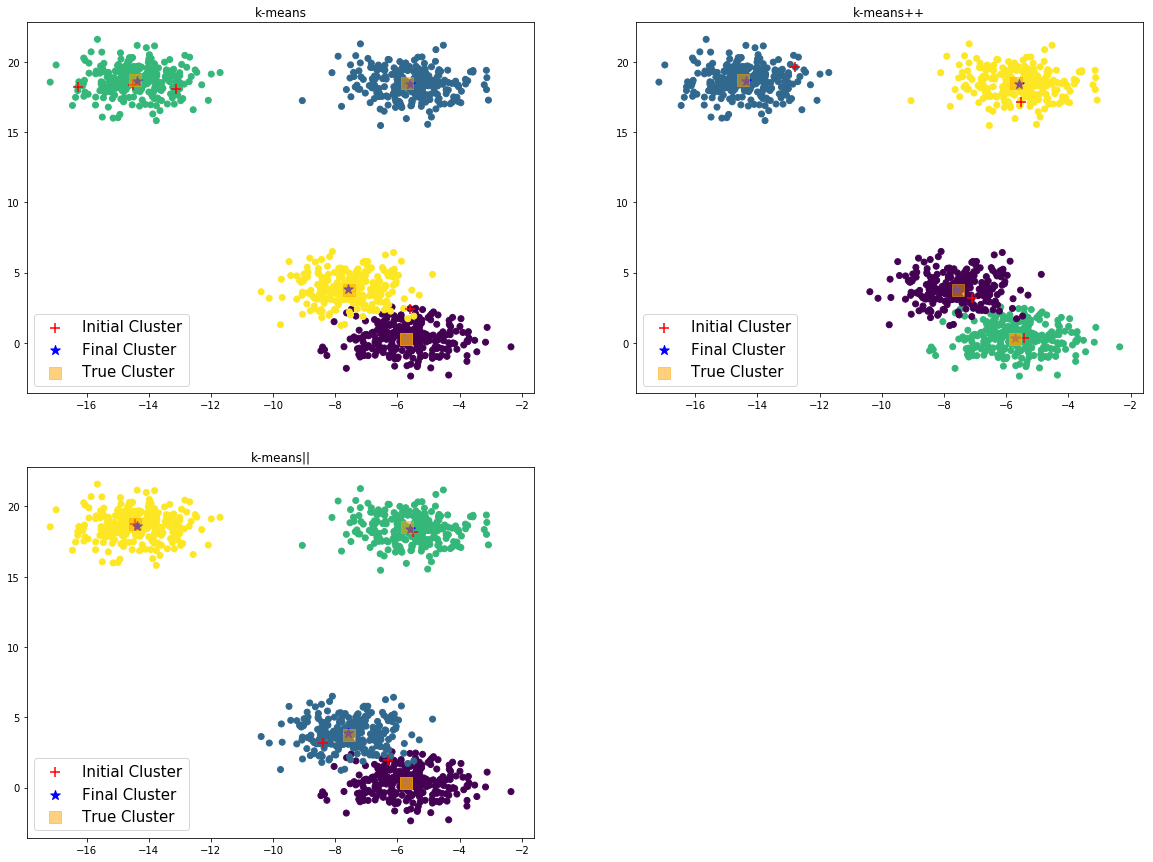

In [32]:
title = ["k-means", "k-means++", "k-means||"]
plt.figure(1, figsize=(20, 15))
for i in np.arange(1, 4):
    plt.subplot(220 + i)
        
    test_cluster(dict['Initial_centroid'][i], dict['Final_centroidtroid'][:,:,i], dict['label'][i],data, title[i - 1])
    for j in range(k):
        if j == 0:
            plt.scatter(true_center[j,0],true_center[j,1],marker = 's', c = 'orange', s= 150, label = "True Cluster",
                       alpha = 0.5)
        plt.scatter(true_center[j,0],true_center[j,1],marker = 's', c = 'orange', s= 150, alpha = 0.5)

        plt.legend(loc='best', prop={'size':15})
plt.show()

From our simulated dataset, we can see that final cluster are really close to true cluster(centroids) in all three algorithms on initializing clusters, but one thing to notice is that, initial centroid for k-means|| are close to the final/true cluster, we expect a faster converagency under k-means||

From the plot we can see that each algorithm can classify the data points correctly in to different groups. and number of cluster is 10 which is the same number we set up afront, then we need to test the output from our jit and cython version with our original version.

In [33]:
k, n, d = 10, 1000, 15
    
mean, cov = np.zeros(d), np.eye(d)
data = np.random.multivariate_normal(mean, cov, n)
    #inrandom initial 
c = np.random.choice(np.arange(len(data)), 10)
c1 = data[c,:]

In [34]:
a = np.ones(data.shape[0])
test1 = kmeans_pp(data,3, a)
test2 = np.asarray(kmeans_pp_cython(a,data, 3))

In [35]:
test1

array([[ 0.01671552,  1.21190195,  0.08496187, -1.42658656,  3.0854642 ,
         0.39612116,  0.27361125,  0.71087448, -0.36818525,  0.56833262,
         0.11874471, -1.21257333,  0.07170326,  1.06444141, -0.11315557],
       [ 0.3193258 ,  1.27999946,  1.30426592,  0.79333395,  0.58201224,
         2.48073908,  1.59818102, -0.72129686,  0.16014449,  1.17332425,
        -0.80285472,  0.78793485, -0.51643485,  1.16379594, -0.5007572 ],
       [-0.25225304,  0.72928923,  1.31063883,  0.08311819,  2.00196243,
        -1.35369121,  0.39748803, -0.27936144, -2.16606876, -1.46917729,
        -1.45315512, -0.3500791 ,  1.20259012, -0.30849455, -0.04914326]])

In [36]:
test2

array([[ 0.01671552,  1.21190195,  0.08496187, -1.42658656,  3.0854642 ,
         0.39612116,  0.27361125,  0.71087448, -0.36818525,  0.56833262,
         0.11874471, -1.21257333,  0.07170326,  1.06444141, -0.11315557],
       [ 0.49079575, -0.12362395,  0.01550219,  1.87569839, -3.18480421,
        -0.1824339 ,  1.33992897,  0.87687262,  1.06578963,  0.2428178 ,
         0.48179545, -0.31931187,  0.81567961, -0.73734646, -1.46786656],
       [-0.25225304,  0.72928923,  1.31063883,  0.08311819,  2.00196243,
        -1.35369121,  0.39748803, -0.27936144, -2.16606876, -1.46917729,
        -1.45315512, -0.3500791 ,  1.20259012, -0.30849455, -0.04914326]])

As we can see, since we can only fix the seed for the first centroid initialization, the centroid will be created after will be random, so we can only test(assert) the dimension of output instead.

In [37]:
np.testing.assert_array_almost_equal(get_weight(c1,data), np.asarray(get_weight_cython(c1,data)))

In [38]:
np.testing.assert_array_almost_equal(kmeans_II_cython(data, 3,10).shape[0], 3)

In [39]:
np.testing.assert_array_almost_equal(jit_kmeans_pp(data, 3,10).shape[0], 3)

In [40]:
np.testing.assert_array_almost_equal(jit_kmeans_II(data, 3,10).shape[0], 3)

In [41]:
np.testing.assert_array_almost_equal(kmeans_II_p(data, 3, l).shape[0], 3)

Therefore, we can see that the dimention(number of centroids) of all the output are consitent with our setting.

### 5.1.3 Time Efficiency

In this subsection, we show the running time of different algorithm in different implementation. We report original, JIT, Cdist, Cython implementations for kmeans++ and kmeansII algorithms. Here we did not show the parallel version in this reprt since after seeing the performance of parallel version, it does not have competitive performace compared with other implmentation, thus we decided to delete this. 

In [42]:
kmeans_pp_time = timer(kmeans_pp, data, k, 1)
jit_kmeans_pp_time = timer(jit_kmeans_pp, data, k, 1)
cdist_kmeans_pp_time = timer(cdist_kmeans_pp, data, k, 1)
ones = np.ones(data.shape[0])
cython_kmeans_pp_time = timer(kmeans_pp_cython, ones, data, k)

kmeans_II_time = timer(kmeans_II, data, k, l, max_iter = 10000)
jit_kmeans_II_time = timer(jit_kmeans_II, data, k, l, max_iter = 10000)
cdist_kmeans_II_time = timer(cdist_kmeans_II, data, k, l, max_iter = 10000)
cython_kmeans_II_time = timer(kmeans_II_cython, data, k, l)

In [43]:
df_simu = time_compare(data, k, l)
df_simu

,k-means++,k-meansII
Original,0.652454,7.352333
JIT,0.002059,1.242855
cdist,0.001807,0.023957
cython,1.666296,1.748435
parallel,NaN,0.884447


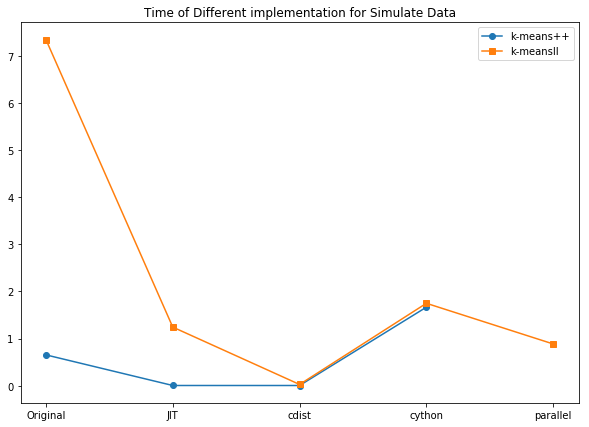

In [44]:
plt.figure(figsize=(10,7))
plt.plot(np.arange(df_simu.shape[0]),np.asarray(df_simu.loc[:, "k-means++"]), label = df_simu.columns[0], marker='o')
plt.plot(np.arange(df_simu.shape[0]),np.asarray(df_simu.loc[:, "k-meansII"]),label = df_simu.columns[1], marker='s')
plt.xticks(np.arange(df_simu.shape[0]), (df_simu.index))
plt.title("Time of Different implementation for Simulate Data")
plt.legend()
plt.show()

In the plot, the orange line is the kmeansII, and the blue line is the kmeans++. We can see that the original method, which is use the most general implementation cost most. JIT and cdist implmentation do a better job than other methods. 

### 5.1.4 Cost

Here we report the cost for general kmeans, kmeans++ and kmeansII. Cost is a function which returns the distance between each point to their centers. All the cost are the final cost, that is to say that we have already found the final centers for each clusters. This is not very surprisely to see that each method gives the relatively similar result. 

In [45]:
def Cost(data, predict):
    dist = distance(data,predict)
    cost = np.sum(np.min(dist,axis=1))
    return cost/(data.shape[0])

In [46]:
print("Cost for random generated data")
random = Cost(data[:-10], dict["Final_centroidtroid"][:,:,1])
kmeans_pp_cost = Cost(data[:-10], dict["Final_centroidtroid"][:,:,2])
kmeans_II_cost = Cost(data[:-10], dict["Final_centroidtroid"][:,:,3])

pd.DataFrame([[random],[kmeans_pp_cost],
                        [kmeans_II_cost]], index = ["random","k-means++", "k-means"],
                        columns = ["Cost"])

Cost for random generated data


,Cost
random,32.38467
k-means++,32.38467
k-means,32.38467


## 5.2 Applications to real data sets - Housing

### 5.2.1 Read data 

In [47]:
housing = np.loadtxt("data/housing.data.txt")
#the sixth column is average number of rooms per dwelling
room = housing[:,5].reshape(-1,1)
#the last column is Median value of owner-occupied homes in $1000's
value = housing[:,-1].reshape(-1,1)
housing = housing[:,(5,-1)]

### 5.2.2 Test - Show plot

In [48]:
dict2 = navie_result(housing, k, l)

Algorithm converged after 30 iterations.
Algorithm converged after 10 iterations.
Algorithm converged after 12 iterations.


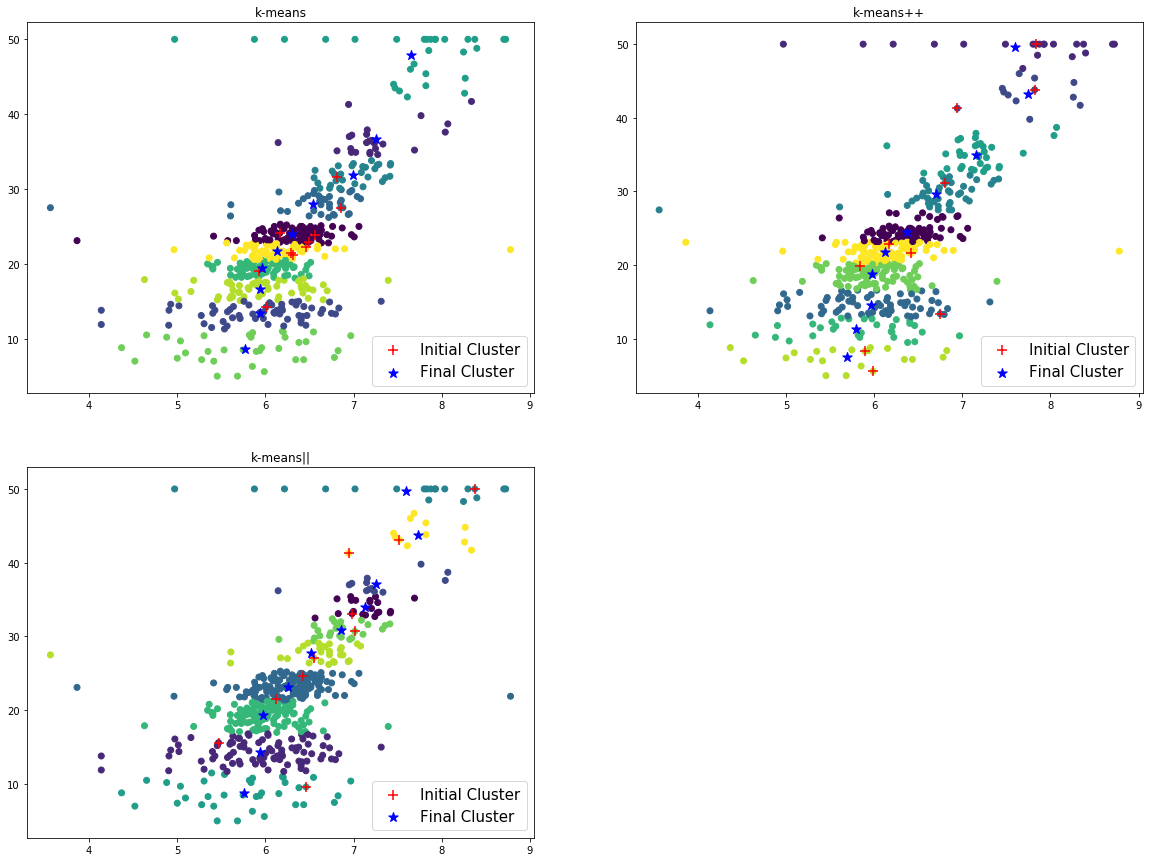

In [49]:
title = ["k-means", "k-means++", "k-means||"]
plt.figure(1, figsize=(20, 15))
for i in np.arange(1, 4):
    plt.subplot(220 + i)
    test_cluster(dict2['Initial_centroid'][i], dict2['Final_centroidtroid'][:,:,i], dict2['label'][i],housing, title[i - 1])

    plt.legend(loc='best', prop={'size':15})
plt.show()


Reference :http://ichrome.com/blogs/archives/221

All three algorithms possess nice seperation of points for this data, however, `k-means||` and `k-means++` have a better initialization for the first cluster(closer to final cluster).

### 5.2.3 Time Efficiency

In [50]:
df_housing = time_compare(housing, k, l)
df_housing

,k-means++,k-meansII
Original,0.073497,1.125506
JIT,0.742349,1.074696
cdist,0.001428,0.013345
cython,0.432806,0.462104
parallel,NaN,1.129807


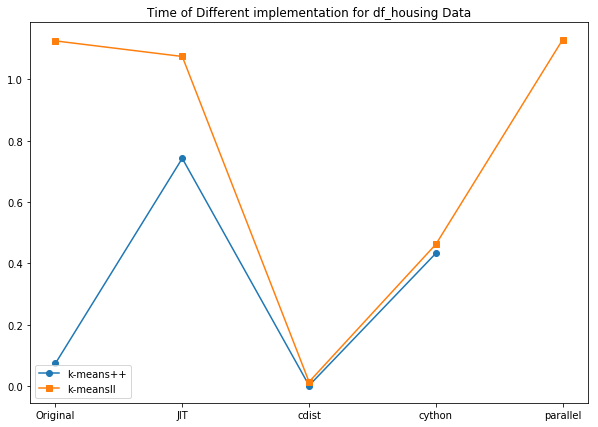

In [51]:
plt.figure(figsize=(10,7))
plt.plot(np.arange(df_housing.shape[0]),np.asarray(df_housing.loc[:, "k-means++"]), label = df_housing.columns[0], marker='o')
plt.plot(np.arange(df_housing.shape[0]),np.asarray(df_housing.loc[:, "k-meansII"]),label = df_housing.columns[1], marker='s')
plt.xticks(np.arange(df_housing.shape[0]), (df_housing.index))
plt.title("Time of Different implementation for df_housing Data")
plt.legend()
plt.show()

The efficiency for `k-means||` with parallel are somewhat unexpected, since we implement similar approach but changing to use map, the result should be at least faster than original. The problem with our cython could be due to for-loop use and fail to use equivalent methods(like `np.random.choice`, `np.vstack` in C instead.

### 5.1.4 Cost

In [52]:
print("Cost for Housing data")
random = Cost(housing, dict2["Final_centroidtroid"][:,:,1])
kmeans_pp_cost = Cost(housing, dict2["Final_centroidtroid"][:,:,2])
kmeans_II_cost = Cost(housing, dict2["Final_centroidtroid"][:,:,3])

pd.DataFrame([[random],[kmeans_pp_cost],
                        [kmeans_II_cost]], index = ["random","k-means++", "k-meansII"],
                        columns = ["Cost"])

Cost for Housing data


,Cost
random,1.019072
k-means++,1.047316
k-meansII,1.129817


## 5.3 Applications to real data sets - Spam base

### 5.3.1 Read data 

In [53]:
spambase = pd.read_csv("http://archive.ics.uci.edu/ml/machine-learning-databases/spambase/spambase.data", header=None)

In [54]:
spambase.head()

,0,1,2,3,4,5,6,7,8,9,...,48,49,50,51,52,53,54,55,56,57
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1


In [55]:
spambase = np.array(spambase)

In [56]:
dict3 = navie_result(spambase, k, l)

Algorithm converged after 108 iterations.
Algorithm converged after 24 iterations.
Algorithm converged after 108 iterations.


### 5.3.2 Time Efficiency

In [57]:
df_spambase = time_compare(spambase, k, l)
df_spambase

,k-means++,k-meansII
Original,9.652046,4.911963
JIT,0.026613,0.351194
cdist,0.024883,0.153399
cython,36.632770,59.959798
parallel,NaN,3.198214


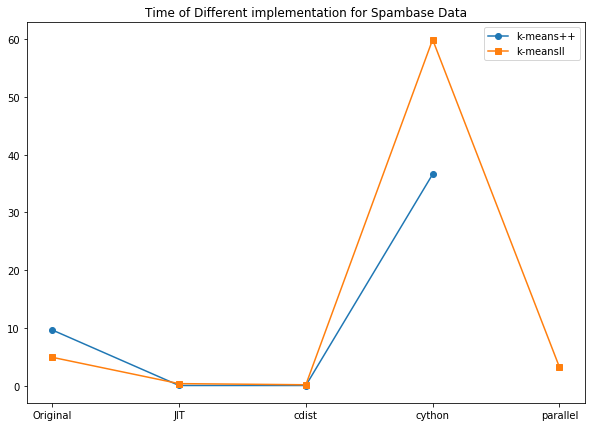

In [58]:
plt.figure(figsize=(10,7))
plt.plot(np.arange(df_spambase.shape[0]),np.asarray(df_spambase.loc[:, "k-means++"]), label = df_spambase.columns[0], marker='o')
plt.plot(np.arange(df_spambase.shape[0]),np.asarray(df_spambase.loc[:, "k-meansII"]),label = df_spambase.columns[1], marker='s')
plt.xticks(np.arange(df_spambase.shape[0]), (df_spambase.index))
plt.title("Time of Different implementation for Spambase Data")
plt.legend()
plt.show()

Compared with the result before, parallel method perform significantly better, I guess that is becasue of different data might cause the problem when using k-means(further discussion are listed below), it might suggest we should use other algorithm for clustering instead for housing data. 

### 5.3.3 Cost

In [59]:
print("Cost for Spambase")
random = Cost(spambase, dict3["Final_centroidtroid"][:,:,1])
kmeans_pp_cost = Cost(spambase, dict3["Final_centroidtroid"][:,:,2])
kmeans_II_cost = Cost(spambase, dict3["Final_centroidtroid"][:,:,3])

pd.DataFrame([[random],[kmeans_pp_cost],
                        [kmeans_II_cost]], index = ["random","k-means++", "k-meansII"],
                        columns = ["Cost"])

Cost for Spambase


,Cost
random,64.288954
k-means++,81.699388
k-meansII,64.288954


It is suprising to see random perform consistently better in these data, further analysis could be focused on the initial cost to see their performance, since the final cost(in this case) are very close(due to randomness?)

# 6 Comparative Analysis

Even though K-means algorithm is so powerful and universally used in a lot of cluster analysis, however, for some dataset, it is preferred to use other algorithm(HAC fo example) intead.

k-Means: Advantages and Disadvantages

Advantages: 
+ Easy to implement	
+ With a large number of variables,	K-Means	may	be computaHonally faster than hierarchical clustering (if K	is	small).	
+ k-Means may produce Hghter clusters than hierarchical clustering
+ An instance can change cluster (move to another cluster) when	the	centroids are recomputed.

Disadvantages:
+ Difficult	to predict the number of clusters (K-Value)	
+ IniHal seeds have	a strong impact	on the final results
+ The order	of the	data has an	impact on the final	results
+ SensiHve to scale: rescaling	your datasets (normalizaHon	or	standardizaHon)	will completely	change	results.	While this itself is bad, not realizing	that you have to spend extra attention on to scaling your data might be	bad.		

	

<br>

Hierarchical Clustering: Advantages and Disadvantages 

Advantages:
+ Hierarchical clustering outputs a hierarchy, ie a structure that is more informaHve than the unstructured set of flat clusters returned by k-means. Therefore, it is easier to decide on the number of clusters by looking at the dendrogram (see suggesHon on how to cut a dendrogram in lab8).
+ Easy to implement.

Disadvantages:
+ It is not possible to undo the previous step: once the instances have been assigned to a cluster, they can no longer be moved around.
+ Time complexity: not suitable for large datasets
+ Initial seeds have a strong impact on the final results
+ The order of the data has an impact on the final results 
+ Very sensitive to outliers“


(Marina	Santini, 2016)

<br>

In [60]:
compareData = np.loadtxt('data/data.csv', delimiter = ',')

In [61]:
x = compareData[:,0]
y = compareData[:,1]

In [62]:
k = 2
dict4 = navie_result(compareData, k, l)

Algorithm converged after 10 iterations.
Algorithm converged after 10 iterations.
Algorithm converged after 18 iterations.


### 6.1 Kmeans

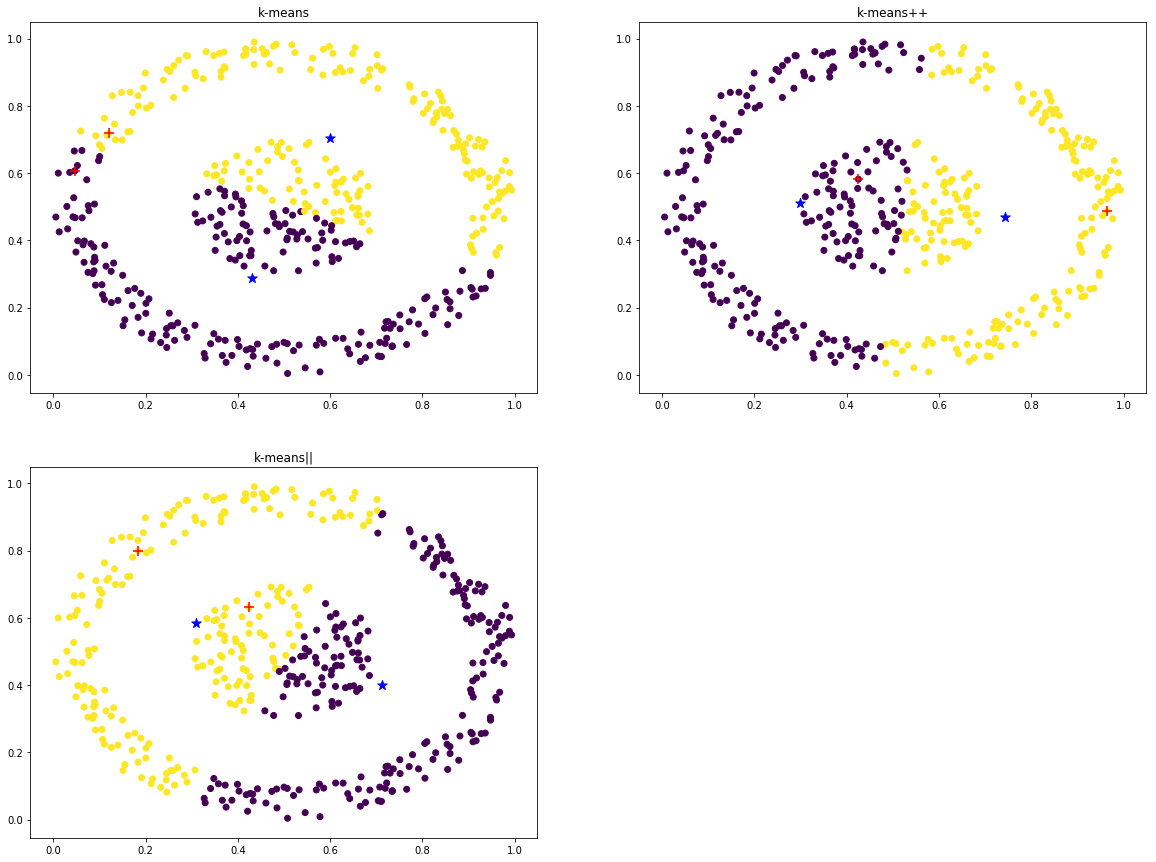

In [63]:
title = ["k-means", "k-means++", "k-means||"]
plt.figure(1, figsize=(20, 15))
for i in np.arange(1, 4):
    plt.subplot(220 + i)
    test_cluster(dict4['Initial_centroid'][i], dict4['Final_centroidtroid'][:,:,i], dict4['label'][i],compareData, title[i - 1])
plt.show()


### 6.2 Hierarchical clustering

Here we use the Agglomerative clustering: 
This is a bottom-up algorithm. That is, each object is initially considered as a single-element cluster, which can be regarded as leaf. At each step of the algorithm, the two clusters that are the most similar are combined into a new bigger cluster, which can be regarded as node. This procedure is iterated until all points are member of just one single big cluster, which is root. Hierarchical clustering does not require us to prespecify the number of clusters. The advantage of hierarchical clustering come at the cost of lower efficiency.

In [64]:
def distance(data,centroids):
    """calculate euclidean distance"""
    dist = np.sum((data[:, np.newaxis, :] - centroids)**2, axis=2)
    return dist

In [65]:
def hac(data, n_cluster):
    #calculate the distance matrix
    d = distance(data, data)
    #make the entry in diagonal and below as infinity since it symmetric and don't care the distance with itself
    d[np.tril_indices_from(d)] = float('inf')
    #initinize the label
    unique_clu = np.arange(len(d))
    while np.unique(unique_clu).size > n_cluster:
        #find the location corresponding to least distance
        x1, x2 = np.where(d == np.min(d))
        #assign the entry label to the minimum label(arbitrarily)
        unique_clu[[x1[0],x2[0]]] = np.min(unique_clu[[x1[0],x2[0]]])
        #replace the distance with infinity (make sure not revisit)
        d[x1[0],x2[0]] = float('inf')
    return unique_clu

In [66]:
unique_clua = hac(compareData, 2)

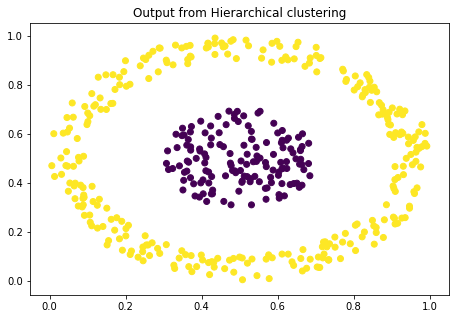

In [67]:
plt.figure(1, figsize=(7.5, 5))
plt.scatter(x, y, c = unique_clua)
plt.title("Output from Hierarchical clustering")
plt.show()

In this specific dataset, we can see that it makes more sense that HAC is better algorithm, since one cluster(sets) of data is lied within the other, the problem when using K-means will arise because of the centroid location.

# 7 Discussion

In this project, we implemented general kmeans, kmeans++ and also kmeansII algorithm. After that we optimized these three algorithms with Just in Time(JIT), Cdist, Cython, and multi-core parallel. We applied these three algorithms with a Gaussian Mixture random generated data, and two real data sets: one is called spambase, which was mentioned in the paper, another one is called housing data set that we found from internet. All the data sets are in data folder<br>
<br>
In each data set, we compared running time of different optimization methods for both kmeans++ and kmeansII. Since we found out that the most time-consuming part is distance part. Thus, we used a function in scipy package called cdist to optimize our algorithms. From the table of running time, we concluded that cdist method is the fastest optimization method. Multi-core parallel method sometimes performed well than others but not better than cdist method. Cython method was not very stable, since its performance varied a lot for different data set. Not surprisingly, the original method is always the lowest one. <br>
<br>
Also, we compared the cost of different algorithms, random center kmeans, kmenas++ and also kmeansII. After we run each algorithm, we created a table to compare cost, surprisingly, we found out that the random center Kmeans has the smallest cost than other two methods. However, each method is very similar to each other. <br>
<br>
In the future, we will focus on exploring the oversampling factor $\ell$ to see how it can affect performance, since how to tune this parameter also need to be investigated. Also, we will pay more attention on how to implement parallel with iparallel.

# 8 Reference

[1] Bahmani, Bahman, Benjamin Moseley, Andrea Vattani, Ravi Kumar, and Sergei Vassilvitskii. "Scalable k-means++." Proceedings of the VLDB Endowment 5, no. 7 (2012): 622-633.<br>
[2] Marina Santini, "Advantages & Disadvantages of k-Means and Hierarchical clustering", 2016. <br>
[3] iChrome, "CLUSTER ANALYSIS – TWO EXAMPLES", 2016